In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from matplotlib import pyplot as plt
%matplotlib inline

David Diaz  
SEFS 590F (Bayesian Models) - Winter 2016-17

## Homework 5

This week the homework is intended to have you practice coding models in JAGS and work on writing up model descriptions and methods. For both problems below, complete the following the tasks:
1. Write the R code with the jags model specification to fit the proposed model.
2. Run your model. Conduct diagnostics to determine convergence (increase the number of iterations if your model has not converged). Examine the sensitivity of your posterior based on the priors you selected (and change your priors if need be).
3. Write up a paragraph describing the model and how it was fitted (prepare this paragraph as though it were to be included in a methods section of a manuscript), and create a table reporting the output from the model (prepare this table as though you were going to use it in a publication – include a caption).  

For each question, submit your paragraph and table along with the R-code.

### 1. Redo the model from the exam, using the manatee dataset. The model is:

$$y_i\sim Normal(\mu_i, \sigma^2)$$
$$\mu_i=r-\frac{r}{K}N_i$$
### Include $K$ as random variable in the model, thus estimating $r$, $K$, and $\sigma^2$. The data are in manatee.csv.

In [2]:
data = pd.read_csv('manatee.csv') # read in the data
y = data.y # assign data vectors to variables
N = data.N

In [3]:
with pm.Model() as model:
    # (vague) priors for unknown model parameters
    r = pm.Gamma(name='r', alpha=0.001, beta=0.001) # these distributions in pymc3 can be...
    K = pm.Gamma(name='K', alpha=0.001, beta=0.001) # parameterized using alpha and beta...
    sigma = pm.InverseGamma(name='sigma', alpha=0.001, beta=0.001) # or mu and sigma
    
    # expected value of outcome
    mu = r - r/K * N
    
    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=y)

In [5]:
with model:
    # draw a trace with 5,000 posterior samples using default pymc3 sampling algorithms for step function
    # initialize values for parameters by finding maximum a posteriori estimates
    trace = pm.sample(draws=5000, init='nuts', n_init=100, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using nuts...
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:47<00:00, 46.69it/s]


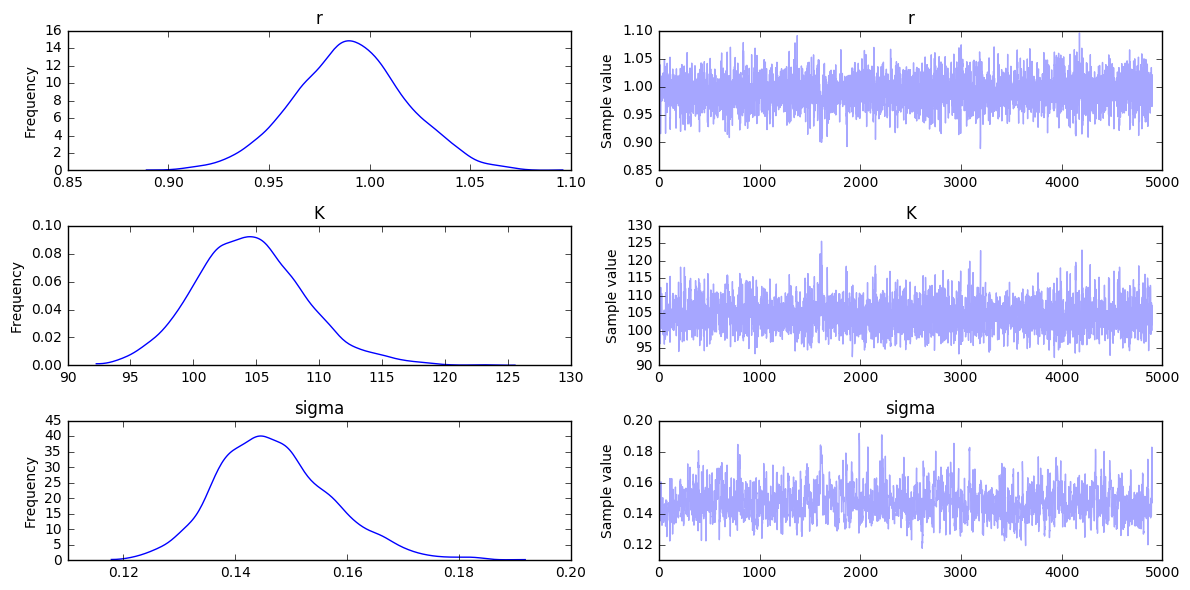

In [17]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:]) # leave out first 100 draws as burn-in
plt.tight_layout()

In [38]:
# generate Geweke diagnostic
# Compares the mean of the first % of a trace with the mean of the last % of the trace. 
# trace is divided into a number of segments for which this difference is computed. 
# If the trace is converged, this score should oscillate between -1 and 1.
scores = pm.diagnostics.geweke(trace[100:], first=0.1, last=0.5, intervals=100)
# compare the first 10% of trace to last 50% of trace using 100 segments

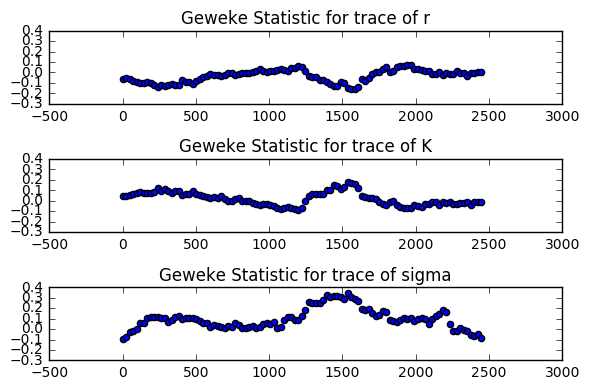

In [39]:
plt.figure()
# geweke of r
ax1 = plt.subplot(311, title='Geweke Statistic for trace of r')
ax1.scatter(x=np.transpose(scores['r'])[0],y=np.transpose(scores['r'])[1])
#geweke of K
ax2 = plt.subplot(312, title='Geweke Statistic for trace of K', sharex=ax1, sharey=ax1)
ax2.scatter(x=np.transpose(scores['K'])[0],y=np.transpose(scores['K'])[1])
# geweke of sigma
ax3 = plt.subplot(313, title='Geweke Statistic for trace of sigma', sharex=ax1, sharey=ax1)
ax3.scatter(x=np.transpose(scores['sigma'])[0],y=np.transpose(scores['sigma'])[1])
plt.tight_layout()

In [42]:
pm.summary(trace)


r:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.988            0.043            0.002            [0.933, 1.044]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.933          0.971          0.990          1.008          1.045


K:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  104.374          4.960            0.147            [95.945, 113.320]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  96.245         101.482        104.289        107.228        114.131


sigma:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------

In this study, the per capita growth rate of manatees, $y$, was modeled as a function of three factors: the intrinsic rate of increase, $r$; the carrying capacity, or population size at which at which the growth rate decreases to zero, $K$; and the current population size, $N$. This takes the form of $y=r-\frac{r}{K}N$. 100 observations of $y$ and $N$ were made of manatees. The observed growth rate for each sample, $y_i$, was modeled using a normal distribution, $y_i\sim N(\mu_i,\sigma^2)$ where $\mu_i=r-\frac{r}{K}N_i$. A Bayesian inference approach was applied, with unobserved parameters in this model ($r$, $K$, and $\sigma$) modeled as random variables drawn from underlying distributions. By considering the likelihood of the observations given values of each parameter as well as the probability distribution for each parameter based on relevant (prior) background information, a posterior probability distribution for each parameter was generated. Vague, or uninformative, estimates were utilized for prior distributions of model parameters, $r\sim gamma(0.001, 0.001)$, $K\sim gamma(0.001,0.001)$, and $\sigma\sim inv.gamma(0.001, 0.001)$. 

Posterior distributions were generated using a Markov Chain Monte Carlo algorithm implemented in Python (v3.5) using the pymc3 package (v3.0). Following initialization of the values for each parameter based on 100 iterations using the No U-Turn Sampler (Hoffman and Gelman, 2011), one chain for each parameter containing 5,000 iterations sampling from the posterior distribution was completed. Traces of each chain were visualized and also evaluated using the Geweke diagnostic statistic (Geweke 1991) to ensure convergence (100 z-scores drawn by segmenting the first 10% and last 50% of each trace were calculated and oscillation between values of -1 and 1 were used to confirm convergence). All code used for implementing for this procedure and visualizations employed to assess it are published online at GitHub (www...). 

The values for model parameters determined from this analysis are reflected in the table below.

<center>*Table 1. Parameters for Model of Manatee Growth Rates*</center>
$$y_i\sim Normal(\mu_i=r-\frac{r}{K}N_i,\sigma^2)$$

Parameter | Mean | StDev | 95% Credible Interval  
:---------:|:-----------:|:-------------------:|:--:|:--:
$r$ | 0.988 | 0.043 | [0.933, 1.044]
$K$ | 104.374 | 0.147 | [95.945, 113.320]
$\sigma$ | 0.147 | 0.000 | [0.129, 0.170]

### 2. Data were collected on willow tit presence in Switzerland (that’s a bird species for the tree and fish folks :) ). The survey includes 237 sites from around the country that were sampled, the presence or absence of willow tits was noted at each site, such that $y_i=1$ indicates that willow tits were present at a site during the survey. Potential covariates that may affect the presence of willow tits, elevation (m) and percent forest cover, were recorded at each site. Fit the following model:  
$y_i\sim Bernoulli(p_i)$  
$logit(p_i) = a_0 + a_1\cdot elev_i + a_2 \cdot elev_{i}^2 + a_3 \cdot forest_i$

In [44]:
willow = pd.read_csv('willowtit.csv') # read in the data
y = willow.y.as_matrix() # assign data vectors to variables
elev = willow.elev.as_matrix()
forest = willow.forest.as_matrix()

# normalize the covariates
z_elev = (elev-np.mean(elev))/np.std(elev)
z_forest = (forest-np.mean(forest))/np.std(forest)

In [56]:
with pm.Model() as willow_model:
    # (vague) priors for unknown model parameters
    a0 = pm.Normal(name='a0', mu=0, sd=100) 
    a1 = pm.Normal(name='a1', mu=0, sd=100) 
    a2 = pm.Normal(name='a2', mu=0, sd=100)
    a3 = pm.Normal(name='a3', mu=0, sd=100)
    prob = pm.Beta(name='prob', alpha=1, beta=1) 
    
    # expected value of outcome
    prob = pm.math.exp(a0 + a1*z_elev + a2*z_elev**2 + a3*z_forest)/(pm.math.exp(a0 + a1*z_elev + a2*z_elev**2 + a3*z_forest)+1)
    
    # likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=prob, observed=y)

In [57]:
with willow_model:
    # draw a trace with 2,000 posterior samples using default pymc3 sampling algorithms for step function
    # initialize values for parameters using 100 draws with NUTS sampler
    willow_trace = pm.sample(draws=2000, init='nuts', n_init=100, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using nuts...
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [16:55<00:00,  3.58it/s]


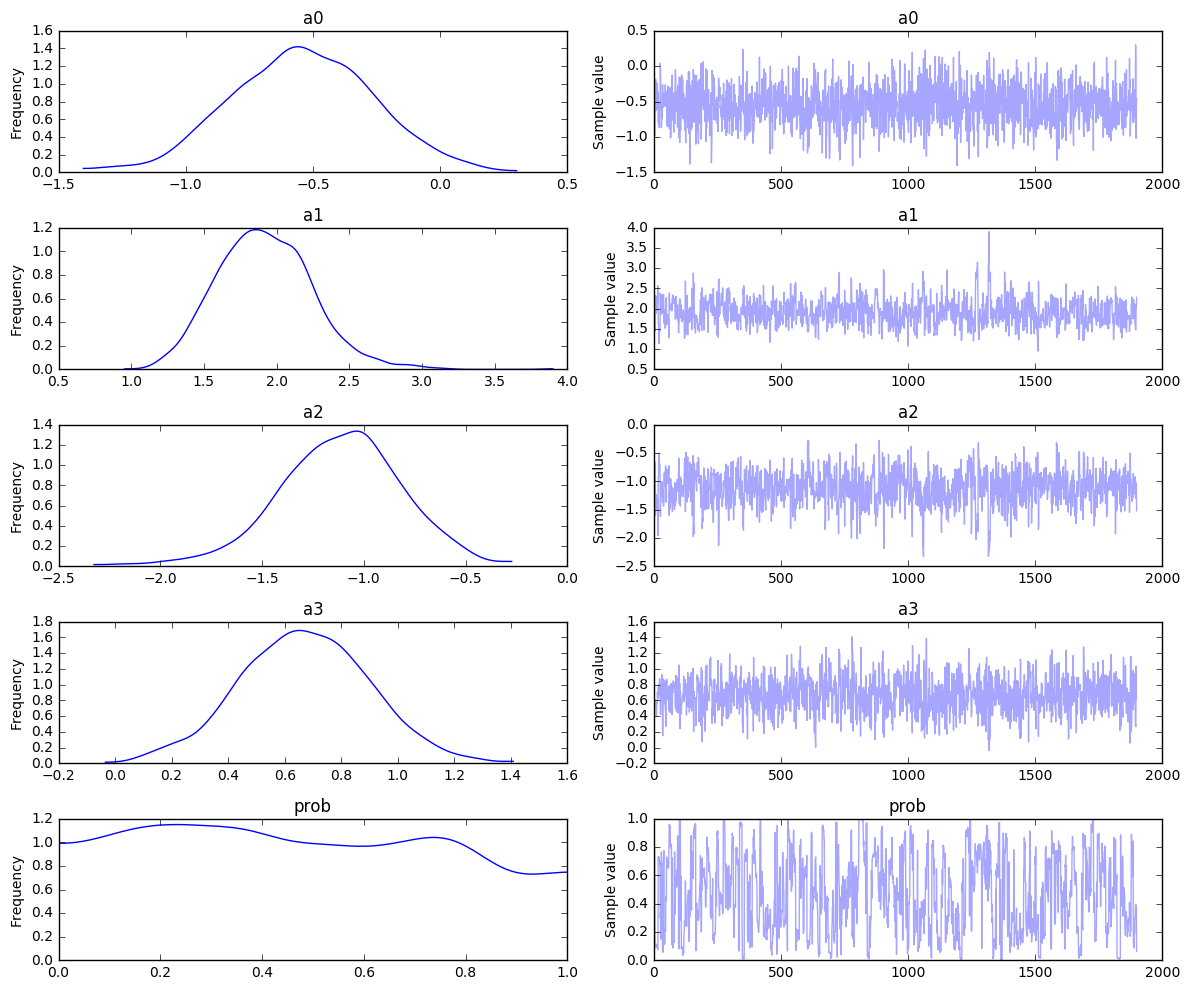

In [58]:
# visualize the traces
plt.figure(figsize=(7, 7))
pm.traceplot(willow_trace[100:]) # leave out first 100 draws as burn-in
plt.tight_layout()

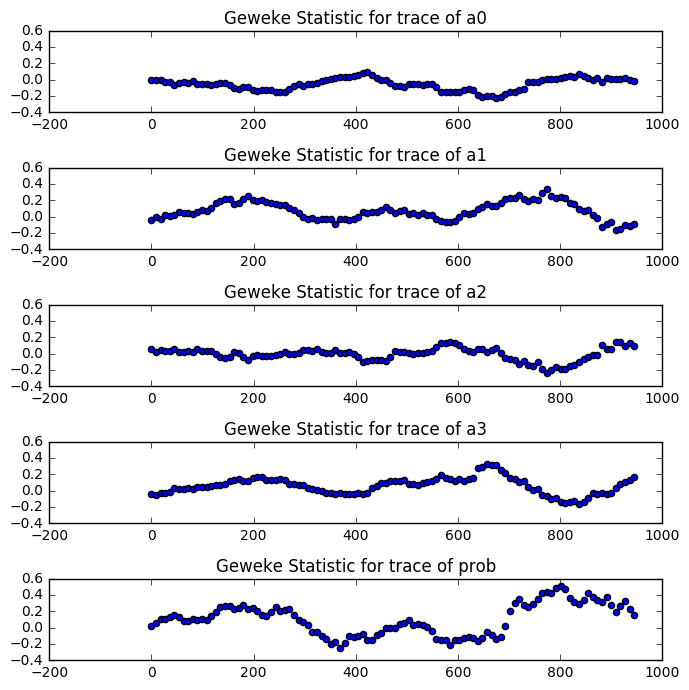

In [59]:
# generate Geweke diagnostic statistic
# If the trace is converged, this z-score should oscillate between -1 and 1.
scores = pm.diagnostics.geweke(willow_trace[100:], first=0.1, last=0.5, intervals=100)
# compare the first 10% of trace to last 50% of trace using 100 segments

plt.figure(figsize=(7, 7))
ax1 = plt.subplot(511, title='Geweke Statistic for trace of a0')
ax1.scatter(x=np.transpose(scores['a0'])[0],y=np.transpose(scores['a0'])[1])
ax2 = plt.subplot(512, title='Geweke Statistic for trace of a1', sharex=ax1, sharey=ax1)
ax2.scatter(x=np.transpose(scores['a1'])[0],y=np.transpose(scores['a1'])[1])
ax3 = plt.subplot(513, title='Geweke Statistic for trace of a2', sharex=ax1, sharey=ax1)
ax3.scatter(x=np.transpose(scores['a2'])[0],y=np.transpose(scores['a2'])[1])
ax4 = plt.subplot(514, title='Geweke Statistic for trace of a3', sharex=ax1, sharey=ax1)
ax4.scatter(x=np.transpose(scores['a3'])[0],y=np.transpose(scores['a3'])[1])
ax5 = plt.subplot(515, title='Geweke Statistic for trace of prob', sharex=ax1, sharey=ax1)
ax5.scatter(x=np.transpose(scores['prob'])[0],y=np.transpose(scores['prob'])[1])
plt.tight_layout()

In [60]:
pm.summary(willow_trace)


a0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.548           0.277            0.007            [-1.093, -0.026]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.089         -0.738         -0.549         -0.360         -0.001


a1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.917            0.324            0.014            [1.282, 2.514]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.338          1.690          1.908          2.126          2.622


a2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------

In this study, the probability ($p_i$) of observing a willow tit was modeled as a function of elevation ($elev$) and perecent forest cover ($forest$) at 237 sites in Sweden. The presence($y_i=1$)/absence($y_i=0$) of willow tits is modeled using a Bernoulli distribution: $y_i\sim Bernoulli(p_i)$. A linear model was employed to predict the probability of willow tit presence of the form $logit(p_i) = a_0 + a_1\cdot elev_i + a_2 \cdot elev_{i}^2 + a_3 \cdot forest_i$. Elevation and forest cover were normalized as z-scores prior to model-fitting. 

A Bayesian inference approach was applied, with unobserved parameters in this model ($p_i$, $a_0$, $a_1$, $a_2$, and $a_3$) modeled as random variables drawn from underlying distributions. By considering the likelihood of the observations given values of each parameter as well as the probability distribution for each parameter based on relevant (prior) background information, a posterior probability distribution for each parameter was generated. Vague, or uninformative, estimates were utilized for prior distributions of model parameters, $a_0$, $a_1$, $a_2$, and $a_3 \sim Normal(0, 10000)$, and $p_i\sim Beta(1,1)$. 

Posterior distributions were generated using a Markov Chain Monte Carlo algorithm implemented in Python (v3.5) using the pymc3 package (v3.0). Following initialization of the values for each parameter based on 100 iterations using the No U-Turn Sampler (Hoffman and Gelman, 2011), one chain for each parameter containing 2,000 iterations sampling from the posterior distribution was completed. Traces of each chain were visualized and also evaluated using the Geweke diagnostic statistic (Geweke 1991) to ensure convergence (100 z-scores drawn by segmenting the first 10% and last 50% of each trace were calculated and oscillation between values of -1 and 1 were used to confirm convergence). Although the parameter values for all $a$ parameters showed convergence around a unimodal distribution, $p_i$ did not appear emerge with a clear unimodal distribution despite relatively stable variance across its trace indicating convergence. 
The values for model parameters determined from this analysis are reflected in the table below.

All code used for implementing for this procedure and visualizations employed to assess it are published online at GitHub (www...). 

<center>*Table 2. Model Parameters for Estimating Probability of Willow Tit Presence in Sweden*</center>
$$logit(p_i) = a_0 + a_1\cdot elev_i + a_2 \cdot elev_{i}^2 + a_3 \cdot forest_i$$

Parameter | Mean | StDev | 95% Credible Interval  
:---------:|:-----------:|:-------------------:|:--:|:--:
$a0$ | -0.548 | 0.277 | [-1.093, -0.026]
$a1$ | 1.917  | 0.324 | [1.282, 2.514]
$a2$ | -1.114 | 0.306 | [-1.675, -0.481]
$a3$ | 0.669  | 0.225 | [0.199, 1.089]
$p_i$ | 0.477 | 0.278 | [0.009, 0.930]

